# **CMPE 258** Final Project
## **Neural Style Transfer** - Understanding Content and Style Representations in CNNs

##### **Group 3** Members || **Krystle Beaulieu** 00741572 || **Esther Hammon** 017530032 || **Jason Lee** 015293408

### Setup

In [1]:
# !pip install requests tqdm
!pip install lpips --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.6 MB/s eta 0:00:00


In [2]:
# General Libraries
import os
import requests
from tqdm import tqdm
import zipfile
import kagglehub
import random

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from PIL import Image

# Evaluation Libraries
import lpips
import time

In [3]:
from google.colab import drive
# Mount to google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set Device Hardware
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


### **Import** Project Modules

In [9]:
# =========================
# CLONE GITHUB REPOSITORY
# =========================
!git clone https://github.com/krymbeaulieu/cmpe258-group3-style-transfer.git
%cd cmpe258-group3-style-transfer
!ls

# # Delete the entire directory
# %cd /content
# !rm -r cmpe258-group3-style-transfer

Cloning into 'cmpe258-group3-style-transfer'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 99 (delta 19), reused 2 (delta 2), pack-reused 67 (from 1)
Receiving objects: 100% (99/99), 52.71 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/cmpe258-group3-style-transfer
CMPE_258_Project_G3_Lee.ipynb	  krystle_scratch.ipynb  style_classifier.py
data_feat_load.py		  losses.py		 train_loop.py
evals.py			  models.py		 train.py
Krystle_one_style_training.ipynb  README.md


In [10]:
# ==========================================
# IMPORT PROJECT MODULES
# ==========================================
from data_feat_load import (get_transforms, load_image, imshow, StyleMeDataset, load_wiki_subset)
from losses import adaptive_instance_normalization, mean_std, gram_matrix, StyleLoss, StyleLossBatch, ContentLoss
from models import UNet
from evals import get_lpips, activation_style_distance, evaluate_style_classifier
from style_classifier import StyleClassifier
from train import style_transfer, get_features, StyleClassTrainer
from train_loop import save_prediction_triplet, train_style_transfer

# from SCTrainer import SCTrainer
# load_wikiart_style_dataset

### Collab Utility Models

###### Style Class Counter

In [11]:
# Quick counter function
def count_style_instances(root_path):
    counts = {}
    for style in sorted(os.listdir(root_path)):
        style_path = os.path.join(root_path, style)
        if not os.path.isdir(style_path):
            continue
        files = [f for f in os.listdir(style_path)]
        counts[style] = len(files)
    return counts

##### Image Grid Function

In [ ]:
import math

def show_image_grid(image_paths,image_names, cols=4, max_images=16):
    paths = image_paths[:max_images]
    rows = math.ceil(len(paths) / cols)
    plt.figure(figsize=(4*cols, 4*rows))
    for i, img_path in enumerate(paths, 1):
        img = Image.open(img_path).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(image_names[i-1])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

##### Activation Heatmap

In [97]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def activation_heatmap(stylized, target, model, layer="conv4_1", cmap="magma", stylized_title="Stylized Image"):

    # Extract VGG features using existing function
    feats_s = get_features(stylized, model)[layer]   # [1,C,H,W]
    feats_t = get_features(target, model)[layer]     # [1,C,H,W]

    # L2 activation difference per spatial location <- collapse channel dimension for heatmap H×W
    diff = torch.norm(feats_s - feats_t, p=2, dim=1).squeeze(0)  # [H,W]

    # Normalize 0–1
    diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)
    diff_np = diff.detach().numpy()

    # Plot heatmap overlayed on stylized image
    plt.figure(figsize=(15,5))

    # Original stylized image
    plt.subplot(1,3,1)
    plt.title(stylized_title)
    plt.imshow(stylized.squeeze().permute(1,2,0).cpu().clamp(0,1))
    plt.axis("off")

    # Target Style Image
    plt.subplot(1,3,2)
    plt.title("Target Style Image")
    plt.imshow(target.squeeze().permute(1,2,0).cpu().clamp(0,1))
    plt.axis("off")

    # Heatmap
    plt.subplot(1,3,3)
    plt.title(f"Activation Heatmap ({layer})")
    plt.imshow(diff_np, cmap=cmap)
    plt.colorbar()
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return diff_np

---
# **Pretrained Style Classifier** Integration
#### Using **ResNet50 Model** - Pretrained on *WikiArt* style classes

Load ResNet-50 model (pretrained on WikiArt) + create a new file style_classifier.py

In [12]:
DATA_DIR = r"/content/drive/MyDrive/CMPE258-Data/ProjectData/"
SAVE_PATH = os.path.join(DATA_DIR, "weights", "stylesubset_classifier_wikiart.pth")
# CHECKPOINT_PATH = DATA_DIR + "checkpoints/classifier_checkpoint.pth"
WIKIART_PATH = DATA_DIR + "wikiart/"
MSCOCO_PATH = DATA_DIR + "mscoco/val2017/"

##### Quick Look @ Instances per Class

In [ ]:
# Usage
folder_counts = count_style_instances(WIKIART_PATH)
for style, cnt in folder_counts.items():
    print(f"{style:30}  {cnt} images")

#### Classifer Configuration

In [ ]:
# ===========================
# CONFIGURATION SETUP
# ===========================
BATCH_SIZE    = 32      # or 16 for img size of 128
LR            = 1e-4
WEIGHT_DECAY  = 1e-4
EPOCHS        = 5       # 5 usually enough for 85–92% accuracy
IMG_SIZE      = 512 if torch.cuda.is_available() else 128  # use small size if no GPU
VAL_SPLIT     = 0.2
PATIENCE      = 4
GRAD_STEP     = 1
SAMPLES_PER_CLASS = 800 # Maximum to maintain balances
SELECTED_STYLES = ["Abstract_Expressionism","Art_Nouveau_Modern",
                   "Baroque","Color_Field_Painting","Cubism",
                   "Early_Renaissance","Expressionism","Fauvism",
                   "High_Renaissance","Impressionism",
                   "Mannerism_Late_Renaissance","Minimalism",
                   "Naive_Art_Primitivism","Northern_Renaissance",
                   "Pointillism","Post_Impressionism","Realism",
                   "Rococo","Romanticism","Symbolism", "Ukiyo_e"]

#### Dataset **Transforms/Loaders** - Train + Validation

In [18]:
# =================================
# TRAIN/VAL SPLIT + DATA LOADERS
# =================================

# Using Subset Loader
train_loader, val_loader, NUM_CLASSES, CLASS_NAMES = load_wiki_subset(root_path=WIKIART_PATH,
                                                                      selected_styles=SELECTED_STYLES,
                                                                      img_size=IMG_SIZE,
                                                                      batch_size=BATCH_SIZE,
                                                                      samples_per_class=SAMPLES_PER_CLASS,
                                                                      val_split=VAL_SPLIT)

# # Quick Look @ Classes
# print(NUM_CLASSES)
# print(CLASS_NAMES)

## **Train Classifer** - WikiArt

In [ ]:
# =================================
# LOAD STYLE CLASSIFIER (WikiArt)
# =================================
classifier = StyleClassifier(NUM_CLASSES).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 253MB/s]


In [ ]:
# Define Trainer
trainer = SCTrainer(
    model = classifier,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    save_path = SAVE_PATH,
    epochs = EPOCHS,
    lr = LR,
    weight_decay = WEIGHT_DECAY,
    patience = PATIENCE)

# Train Classifer
trainer.train()

###### Pause/Save Training:

In [ ]:
# Un-Pause Training:
checkpoint_path = "/content/drive/MyDrive/CMPE258-Data/ProjectData/checkpoints/classifier_partial_subset.pth"

# Rebuild model & trainer first
classifier = StyleClassifier(NUM_CLASSES).to(DEVICE)

# Define Trainer
trainer = SCTrainer(
    model = classifier,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    save_path = SAVE_PATH,
    epochs = EPOCHS,
    lr = LR,
    weight_decay = WEIGHT_DECAY,
    patience = PATIENCE)

# Load the checkpoint saved earlier
checkpoint = torch.load(checkpoint_path,map_location=DEVICE)
# # Load checkpoint on CPU if trained on GPU
# checkpoint = torch.load('checkpoint.pth', map_location=torch.device('cpu'))
classifier.load_state_dict(checkpoint['model'])
trainer.optimizer.load_state_dict(checkpoint['optimizer'])
trainer.start_epoch = 2 #checkpoint["epoch"]
print("Checkpoint loaded, resuming training with pre-trained weights.")

# Continue from where it left off
trainer.train()

Checkpoint loaded, resuming training with pre-trained weights.
Starting Style Classifier Training


Epoch 3/5: 100%|██████████| 263/263 [1:00:57<00:00, 13.91s/it, loss=0.9010]


Epoch 3: Train Loss=0.9010, Val Acc=0.6500
New Best Model Saved — Val Acc: 0.6500


Epoch 4/5: 100%|██████████| 263/263 [02:25<00:00,  1.81it/s, loss=0.6056]


Epoch 4: Train Loss=0.6056, Val Acc=0.6867
New Best Model Saved — Val Acc: 0.6867


Epoch 5/5: 100%|██████████| 263/263 [02:28<00:00,  1.77it/s, loss=0.3735]


Epoch 5: Train Loss=0.3735, Val Acc=0.7376
New Best Model Saved — Val Acc: 0.7376
Training Completed — Best Val Acc: 0.7376190476190476
Best model saved to: /content/drive/MyDrive/CMPE258-Data/ProjectData/weights/stylesubset_classifier_wikiart.pth


## Test Style Classifer

Load Classifer Model

In [20]:
# from style_classifier import StyleClassifier

NUM_CLASSES = len(SELECTED_STYLES)
# Rebuild model architecture
classifier = StyleClassifier(NUM_CLASSES).to(DEVICE)

# Load the model weights
classifier.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
classifier.eval() # Set to eval mode

# Freeze model for evaluation
for param in classifier.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


StyleClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

### Test Classifier - All Style Classes

##### Generate Random Class Samples

In [ ]:
# import random
# Classes Trained:
style_names = sorted(SELECTED_STYLES)

style_paths = []
style_labels = []
images_per_class = 15   # 10-20 needed for stable CM
for idx, style_name in enumerate(style_names):
    folder = os.path.join(WIKIART_PATH, style_name)
    images = [f for f in os.listdir(folder)]
    img_subset = random.sample(images, min(images_per_class, len(images)))
    for img_name in img_subset:
        img_path = os.path.join(folder, img_name)
        style_paths.append(img_path)
        style_labels.append(idx)

# # Print Images
# for img_path in style_paths:
#     img = Image.open(img_path)
#     plt.imshow(img)
#     plt.axis("off")
#     plt.show()

#### Run Evaluation + Classification Report + Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

acc, conf, preds = evaluate_style_classifier(classifier, style_paths, style_labels, device=DEVICE, img_size=IMG_SIZE)

print("Classifier Evaluation Result")
print(f"Total Accuracy:     {acc:.4f}")
print(f"Avg True-Class Conf {conf:.4f}")

# ---- Print full classification report ----
print("\nClassification Report:")
print(classification_report(style_labels, preds, target_names=style_names))


Classifier Evaluation Result
Total Accuracy:     0.5000
Avg True-Class Conf 0.4623

Classification Report:
                            precision    recall  f1-score   support

    Abstract_Expressionism       0.44      0.40      0.42        10
        Art_Nouveau_Modern       0.75      0.30      0.43        10
                   Baroque       0.33      0.20      0.25        10
      Color_Field_Painting       0.62      0.50      0.56        10
                    Cubism       0.60      0.90      0.72        10
         Early_Renaissance       0.54      0.70      0.61        10
             Expressionism       0.17      0.20      0.18        10
                   Fauvism       0.36      0.90      0.51        10
          High_Renaissance       0.75      0.30      0.43        10
             Impressionism       0.43      0.90      0.58        10
Mannerism_Late_Renaissance       0.70      0.70      0.70        10
                Minimalism       0.58      0.70      0.64        10
     Na

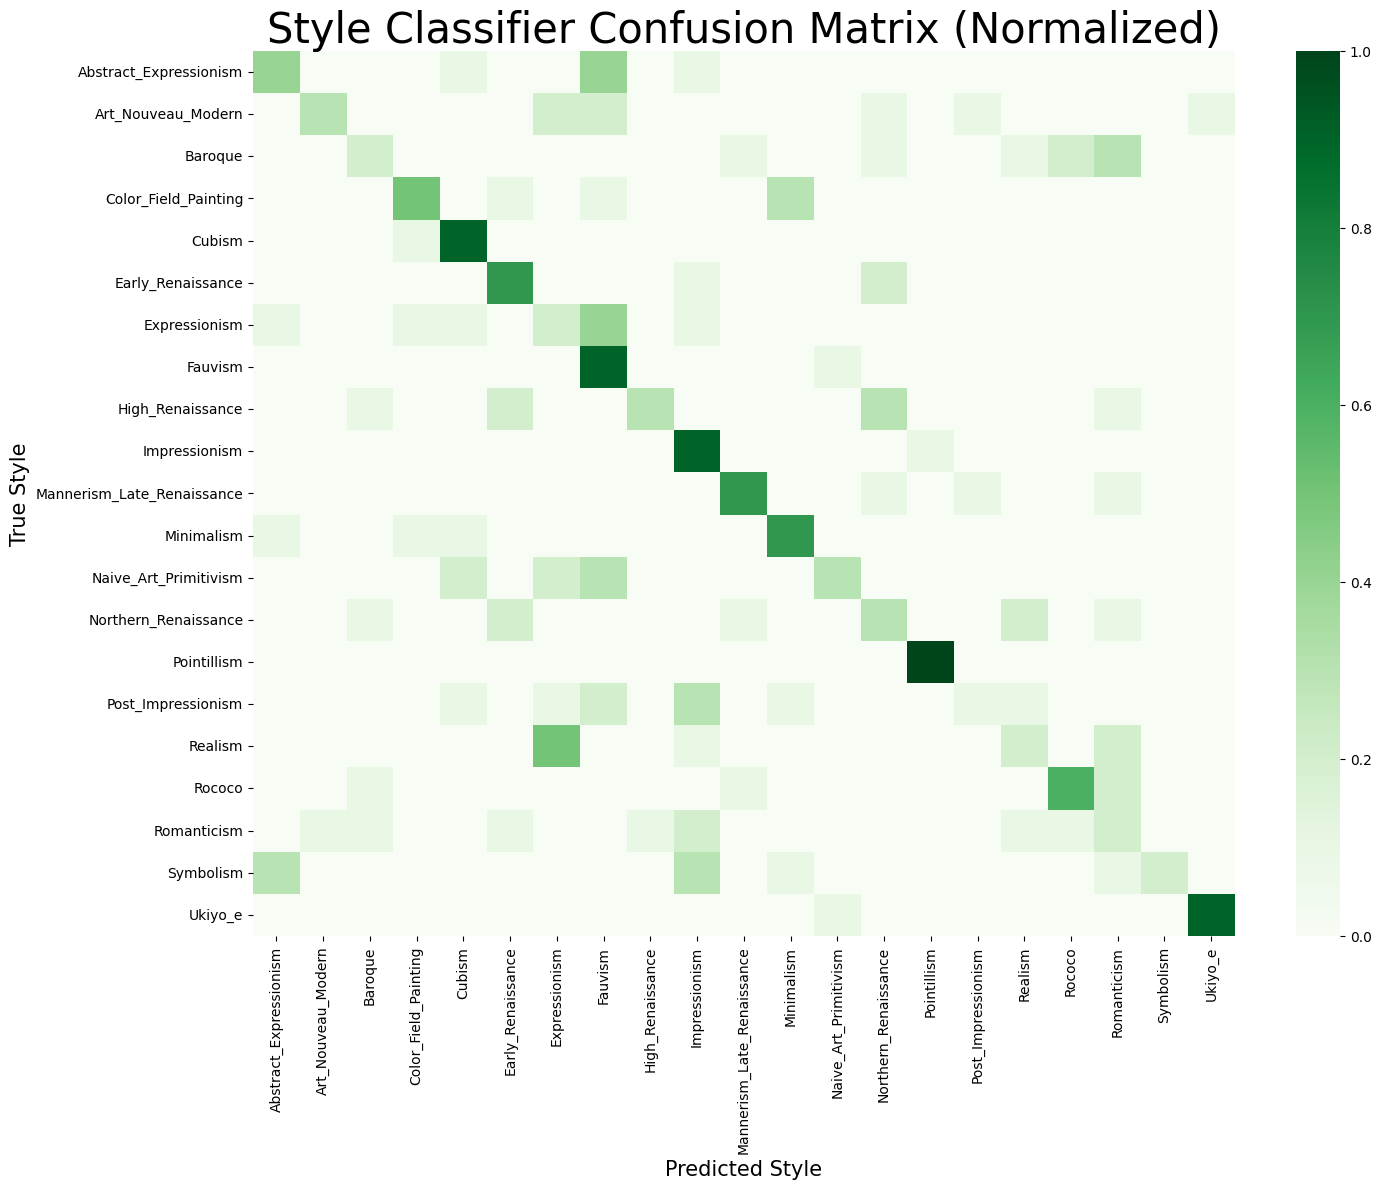

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(style_labels, preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalization (per row)

# Plot Heatmap
plt.figure(figsize=(15,12))
sns.heatmap(cm_normalized, annot=False, cmap="Greens", xticklabels=style_names, yticklabels=style_names, fmt=".2f")
plt.xlabel("Predicted Style",fontsize=15)
plt.ylabel("True Style",fontsize=15)
plt.title("Style Classifier Confusion Matrix (Normalized)",fontsize=30)
plt.tight_layout()
plt.show()

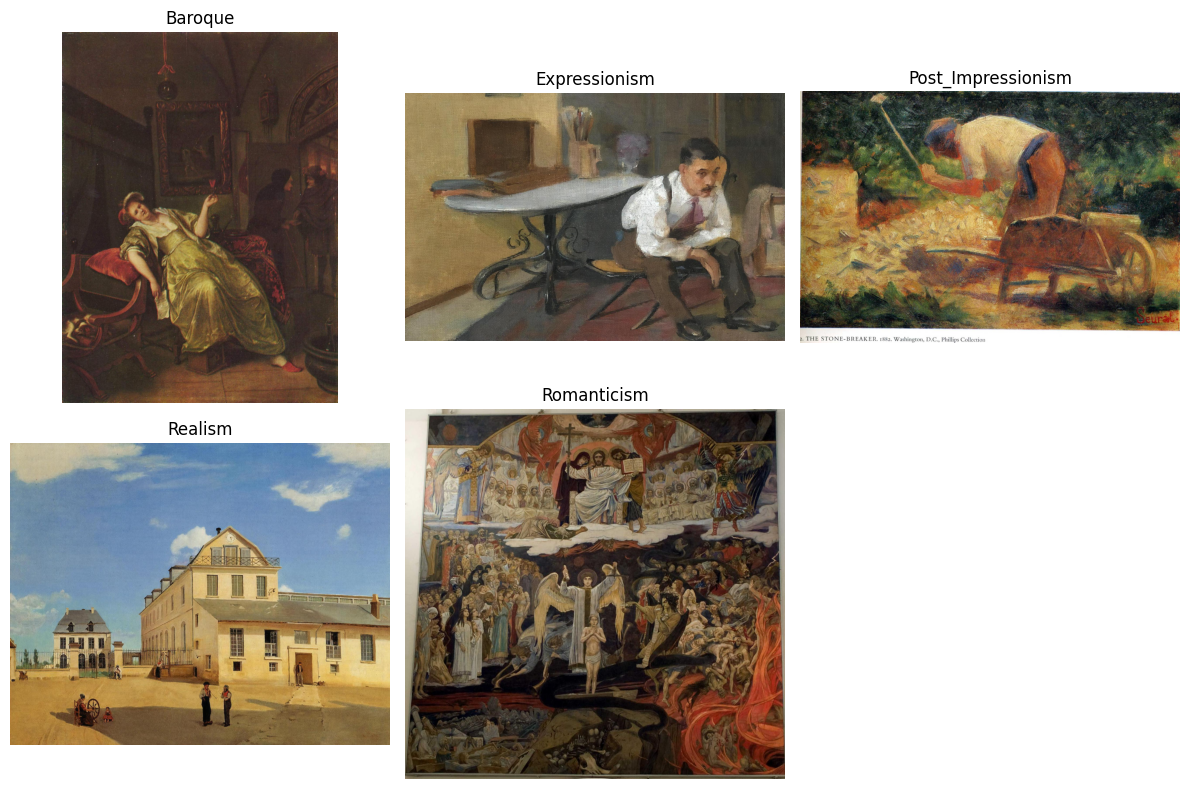

In [ ]:
show_image_grid(lowest_paths,lowest_names, cols=4, max_images=5)

Testing the model showed the some of the lowest performing classes tended to have similar features at lower activation layers. However, the classifer model requires more training (i.e. increased epochs, more samples per class, etc.) to improve accuracy.

Model especially struggled with differentiating between Expressionism and Post-Impressionism, which is understandable considering that Expressionism was greatly influenced by the Post-Impressionism.

---
# **Style Transfer Evaluation:**

##**Gram Style Transfer** - Giraffe + Action Painting

##### Load **Content** + **Style**  + **Stylized** Images

In [ ]:
# ==========================================
# LOAD CONTENT + TARGET STYLE + STYLIZED
# ==========================================

# Stylized Examples from Krystle
stylized_path = DATA_DIR + "stylized_imgs/step_5000_loss_gram_cw_0.5_sw_1000000.0_actionpaint_giraffe.JPG"
target_path = DATA_DIR + "stylized_imgs/walasse-ting_it-is-very-hot-here-1986.JPG"
content_path = DATA_DIR + "stylized_imgs/000000557176_giraffe.JPG"
true_style = "Action_painting"

# Load Images
stylized = load_image(stylized_path, get_transforms(IMG_SIZE), DEVICE) # IMG_SIZE = 512
target = load_image(target_path, get_transforms(IMG_SIZE), DEVICE)
content = load_image(content_path, get_transforms(IMG_SIZE), DEVICE)

# Plot content and style image
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
imshow(content, "Content")
plt.subplot(1,3,2)
imshow(target, "Target")
plt.subplot(1,3,3)
imshow(stylized, "Gram - Stylized")
plt.tight_layout()
plt.show()


##### **LPIPS** – Perceptual Similarity Score to Content Image

In [81]:
from torchvision.models import vgg19, VGG19_Weights

# Load Pretrained VGG19 w/ weights
vgg19 = vgg19(weights=VGG19_Weights.DEFAULT).features.to(DEVICE).eval() # Set to evaluation model (no gradient tracking)

In [75]:
import lpips

# LPIPS (VGG backbone)
lpips_model = lpips.LPIPS(net='vgg').to(DEVICE).eval()
lpips_dist = lpips_model(content, stylized)
print(f"LPIPS Distance (content vs stylized): {lpips_dist.item():.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS Distance (content vs stylized): 0.7442


#####  **Activation Embedding** Distance

L2 Activation Distance: 9.635749816894531
Cosine Similarity: 0.9649091362953186


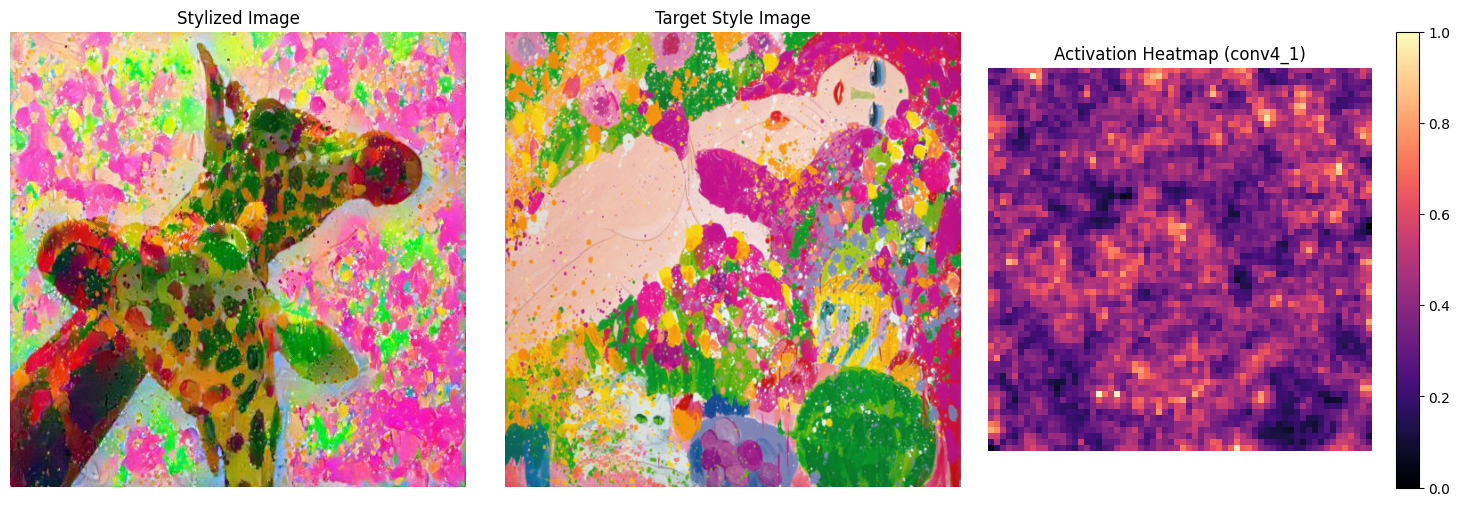

In [76]:
# Calculate Embedding Distances
l2, cos = activation_style_distance(stylized, target, vgg19)
print("L2 Activation Distance:", l2)
print("Cosine Similarity:", cos)

# Print Activation HeatMap
heat = activation_heatmap(stylized, target, vgg19, layer="conv4_1")

**L2 Activation Distance**

- Lower = stylized activation is closer to target style activation

- Higher = stylized image is activating VGG differently (worse style match)

***Moderate Distance (5 – 15)*** - Good stylization. Most reasonable stylized images fall here.
* Stylized image captures most style features

* Still retains some content features

* This is the range you want for balanced stylization.


**Cosine Similarity** - Usually 0.7–0.9 for lower L2

- +1.0 → identical activation direction (perfect match)

- 0.0 → unrelated

- –1.0 → opposite (almost never happens with real images)

##### **Classify Gram Style Transfer Output** - Top 5 Predictions

In [77]:
# Style Classifier Score – Does classifier predict the intended style?

style_names = sorted(SELECTED_STYLES)
with torch.no_grad():
    logits = classifier(stylized.to(DEVICE))
    probs = torch.softmax(logits, dim=1)[0]   # shape: [NUM_CLASSES]

# Get top-5 classes
topk_probs, topk_indices = torch.topk(probs, k=5)

print("\nTop-5 Predicted Styles for Stylized Image:\n")
for idx, p in zip(topk_indices.tolist(), topk_probs.tolist()):
    print(f"  {style_names[idx]:30s}  →  {p:.4f}")



Top-5 Predicted Styles for Stylized Image:

  Abstract_Expressionism          →  0.7453
  Color_Field_Painting            →  0.0927
  Fauvism                         →  0.0896
  Expressionism                   →  0.0176
  Pointillism                     →  0.0174


##**AdaIn vs Gram** Style Transfer - Street + Starry Night

##### Load **Content** + **Style**  + **Stylized** Images

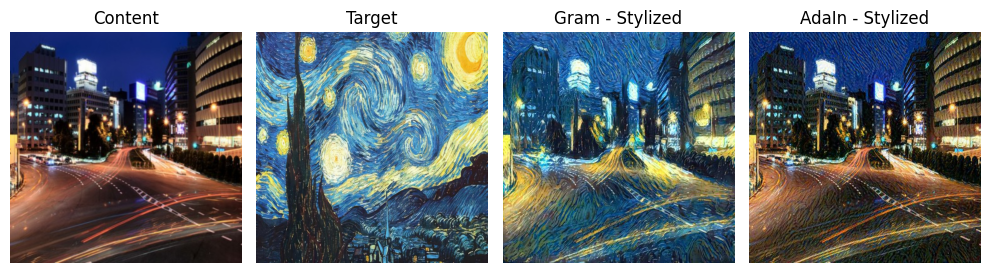

In [94]:
# ==========================================
# LOAD CONTENT + TARGET STYLE + STYLIZED
# ==========================================

# Style and Content Images
target_path = WIKIART_PATH + "Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg"
content_path = DATA_DIR + "stylized_imgs/000000115526.jpg"
true_style = "Post Impressionism"

# Stylized Examples from Krystle
gram_path = DATA_DIR + "stylized_imgs/step_5000_loss_gram_cw_0.5_sw_1000000.0_starry_road.JPG"
adain_path = DATA_DIR + "stylized_imgs/step_500_loss_adain_cw_0.5_sw_10_starry_road.JPG"

IMG_SIZE = 512
target = load_image(target_path, get_transforms(IMG_SIZE), DEVICE)
content = load_image(content_path, get_transforms(IMG_SIZE), DEVICE)
gram_stylized = load_image(gram_path, get_transforms(IMG_SIZE), DEVICE)
adain_stylized = load_image(adain_path, get_transforms(IMG_SIZE), DEVICE)

# Plot content and style image
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
imshow(content, "Content")
plt.subplot(1,4,2)
imshow(target, "Target")
plt.subplot(1,4,3)
imshow(gram_stylized, "Gram - Stylized")
plt.subplot(1,4,4)
imshow(adain_stylized, "AdaIn - Stylized")
plt.tight_layout()
plt.show()


##### **LPIPS** – Perceptual Similarity Score to Content Image

In [82]:
import lpips

# LPIPS (VGG backbone)
lpips_model = lpips.LPIPS(net='vgg').to(DEVICE).eval()
lpips_gram = lpips_model(content, gram_stylized)
lpips_adain = lpips_model(content, adain_stylized)

print("LPIPS Distance (content vs stylized)\n")
print(f"Gram LPIPS Distance: {lpips_gram.item():.4f}")
print(f"AdaIn LPIPS Distance: {lpips_adain.item():.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS Distance (content vs stylized)

Gram LPIPS Distance: 0.6038
AdaIn LPIPS Distance: 0.4401


#####  **Activation Embedding** Distance

In [85]:
# Calculate Embedding Distances
l2_gram, cos_gram = activation_style_distance(gram_stylized, target, vgg19)
l2_adain, cos_adain = activation_style_distance(adain_stylized, target, vgg19)

print(f"L2 Activation Distance:\nGram = {l2_gram:.4f} \nAdaIN = {l2_adain:.4f}\n")
print(f"Cosine Similarity:\nGram = {cos_gram:.4f} \nAdaIN = {cos_adain:.4f}")

L2 Activation Distance:
Gram = 6.1848 
AdaIN = 8.4116

Cosine Similarity:
Gram = 0.9782 
AdaIN = 0.9603


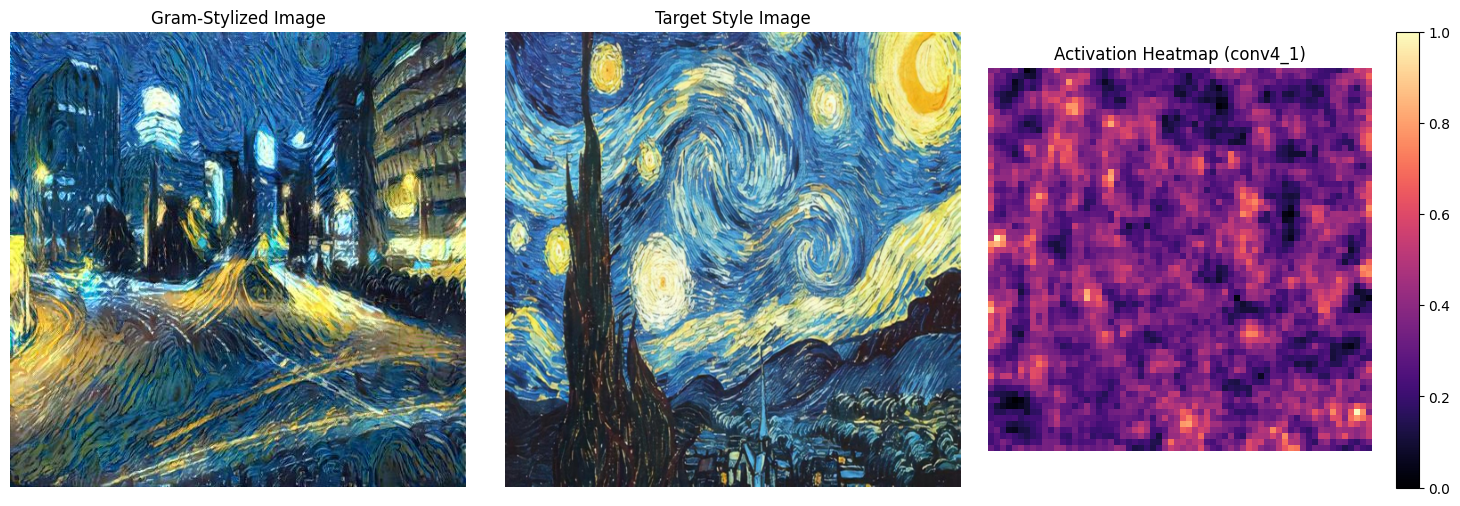

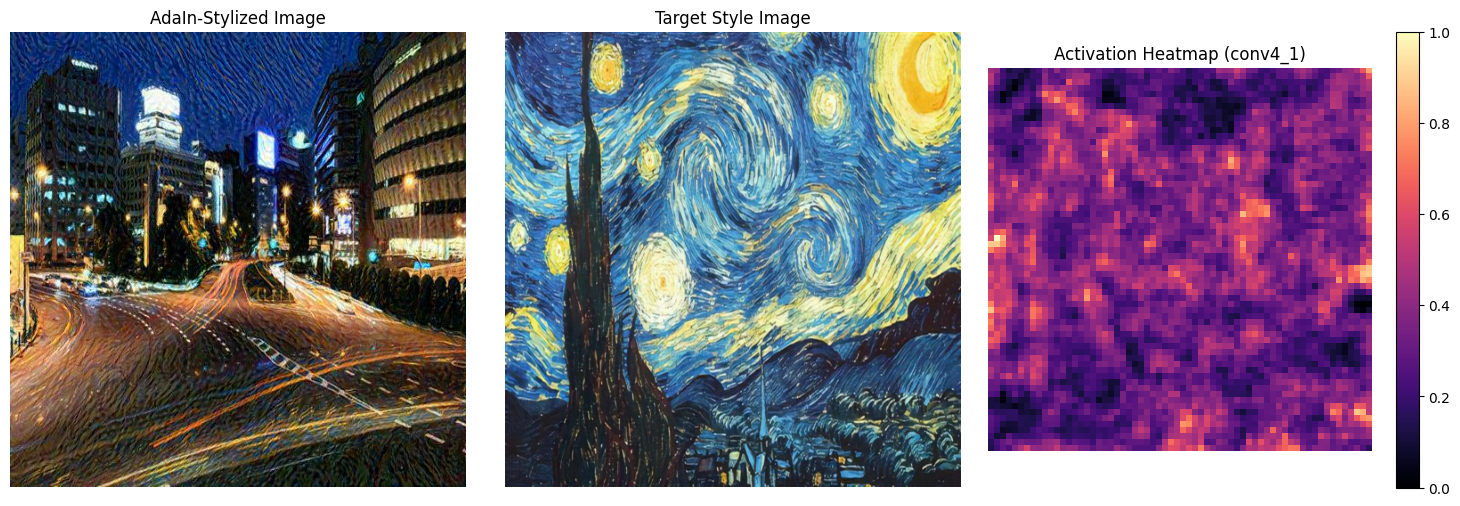

In [98]:
# Print Activation HeatMap
heat_gram = activation_heatmap(gram_stylized, target, vgg19, layer="conv4_1", stylized_title="Gram-Stylized Image")
heat_adain = activation_heatmap(adain_stylized, target, vgg19, layer="conv4_1", stylized_title="AdaIn-Stylized Image")

##### **Classify Gram Style Transfer Output** - Top 5 Predictions

In [95]:
# Style Classifier Score – Does classifier predict the intended style?

style_names = sorted(SELECTED_STYLES)

with torch.no_grad():
    glogits = classifier(gram_stylized.to(DEVICE))
    gram_probs = torch.softmax(glogits, dim=1)[0]
    alogits = classifier(adain_stylized.to(DEVICE))
    adain_probs = torch.softmax(alogits, dim=1)[0]

# Get top-5 classes
topk_probs_gram, topk_indices_gram = torch.topk(gram_probs, k=5)
topk_probs_adain, topk_indices_adain = torch.topk(adain_probs, k=5)

print(f"Intended Style: {true_style}")
print("\nTop-5 Predicted Styles for Gram-Stylized Image:\n")
for idx, p in zip(topk_indices_gram.tolist(),topk_probs_gram.tolist()):
    print(f"  {style_names[idx]:30s}  →  {p:.4f}")

print("\nTop-5 Predicted Styles for AdaIn-Stylized Image:\n")
for idx, p in zip(topk_indices_adain.tolist(),topk_probs_adain.tolist()):
    print(f"  {style_names[idx]:30s}  →  {p:.4f}")



Intended Style: Post Impressionism

Top-5 Predicted Styles for Gram-Stylized Image:

  Expressionism                   →  0.9310
  Abstract_Expressionism          →  0.0271
  Impressionism                   →  0.0094
  Naive_Art_Primitivism           →  0.0065
  Post_Impressionism              →  0.0060

Top-5 Predicted Styles for AdaIn-Stylized Image:

  Expressionism                   →  0.5687
  Abstract_Expressionism          →  0.1144
  Art_Nouveau_Modern              →  0.0814
  Impressionism                   →  0.0700
  Minimalism                      →  0.0618


### **Optional** Evaluation Methods - Future Work

##### **FID** – Style Distribution Similarity

In [ ]:
# !pip install torch-fidelity
from torch_fidelity import calculate_metrics

FID_results = calculate_metrics(
    input1=target_path,      # Folder of target style images
    input2=stylized_path,    # Folder of generated stylized images
    fid=True,
    verbose=True)

print("FID Score:", FID_results["frechet_inception_distance"])


##### **CLIP Score Method**


CLIP (Radford et al. 2021) is a cross-modal model pre-trained on 400M image-caption pairs and can be used for robust automatic evaluation of the accuracy between images and text prompt (Hessel et al. 2021).

CLIP Score can measure the similarity between text prompt and the artistic style images. As shown in Tab. 1, “Ground Truth” denotes the similarity between text prompt and the collection of artworks. Taking the collection of artworks from Van Gogh as an example we,
- Calculated the mean of similarity between 401 artistic images and a text (a painting by Van Gogh).
- Also calculate the mean of similarity between the 1,000 stylized image and a text prompt.
- Employed the same strategy to calculate the CLIP score for the other collection of artworks, such as Morisot, Ukiyoe, Monet, etc.

As shown in Tab. 1, our method achieves a higher CLIP score compared to other state-of-the-art methods, and is even close to the ground truth score.

[source link](https://arxiv.org/html/2312.06135v1)

---
# ARCHIVE

### Data Loader Method

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import torch
import os

# -------------------------------------------------------------------
# Style Classifier Transforms + DataLoader Utilities
# -------------------------------------------------------------------

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def load_wiki_subset(root_path, selected_styles, img_size=256, batch_size=32, samples_per_class=500, val_split=0.2, num_workers=4,seed=42):
    """
    Loads a balanced subset of WikiArt using selected style folders
    """
    # Define transforms
    train_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

    val_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

    # Build filtered list of files
    all_images = []
    all_labels = []
    class_to_idx = {}
    idx_to_class = {}

    for idx, style in enumerate(selected_styles):
        style_dir = os.path.join(root_path, style)
        if not os.path.isdir(style_dir):
            print(f"Check if style folder exists: {style_dir}")
            continue

        # Map label index
        class_to_idx[style] = idx
        idx_to_class[idx] = style
        files = [os.path.join(style_dir, f) for f in os.listdir(style_dir)]

        # Limit to N samples per style
        files = files[:samples_per_class]
        all_images.extend(files)
        all_labels.extend([idx] * len(files))

    # Create custom dataset structure
    class SubsetWikiArt(torch.utils.data.Dataset):
        def __init__(self, img_paths, labels, transform):
            self.img_paths = img_paths
            self.labels = labels
            self.transform = transform
        def __len__(self):
            return len(self.img_paths)
        def __getitem__(self, idx):
            path = self.img_paths[idx]
            img = Image.open(path).convert("RGB")
            img = self.transform(img)
            label = self.labels[idx]
            return img, label

    # Subset wikiart
    full_train_set = SubsetWikiArt(all_images, all_labels, train_tfms)
    full_val_set   = SubsetWikiArt(all_images, all_labels, val_tfms)

    # Train/Val Split
    total = len(all_images)
    val_size = int(total * val_split)
    train_size = total - val_size
    gen = torch.Generator().manual_seed(seed)
    train_idx, val_idx = random_split(range(total), [train_size, val_size], generator=gen)
    train_dataset = Subset(full_train_set, train_idx.indices)
    val_dataset   = Subset(full_val_set, val_idx.indices)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, len(selected_styles), selected_styles


Checking Loader Outputs:

In [ ]:
# Check Loader Outputs
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

train_count = len(train_loader.dataset)
val_count = len(val_loader.dataset)

print("Train samples:", train_count)
print("Val samples:", val_count)

batch = next(iter(train_loader))
imgs, labels = batch

print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)
print("Min/Max pixel:", imgs.min().item(), imgs.max().item())
print("dtype:", imgs.dtype)
print("Labels:", labels[:10])

### ResNet50 Style Classifer Trainer

In [ ]:
# ==========================================
# ResNet Style Classifier - Training Class
# ==========================================
class SCTrainer:
    def __init__(self, model, train_loader, val_loader, device, save_path, snapshot_path, epochs=10, lr=1e-4, weight_decay=1e-4, patience=4,):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Saving Paths
        self.save_path = save_path
        self.snapshot_path = snapshot_path

        # Hyperparameters
        self.epochs = epochs
        self.start_epoch = 0
        self.lr = lr
        self.weight_decay = weight_decay
        self.patience = patience

        # Loss Function
        self.criterion = torch.nn.CrossEntropyLoss()

        # AdamW Optimizer + Cosine Annealing LR Scheduler
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.epochs, eta_min=1e-6)

        # Early Stopping
        self.best_acc = 0
        self.p_count = 0 # patience counter

    # TRAINING LOOP
    def train(self):
        print("Starting Style Classifier Training")
        for epoch in range(self.start_epoch, self.epochs):
            self.model.train()
            # self.optimizer.zero_grad()
            self.optimizer.zero_grad(set_to_none=True) # reduce memory + speed things up slightly
            running_loss = 0
            progress = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}")
            for i, (imgs, labels) in enumerate(progress):
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)
                logits = self.model(imgs)
                loss = self.criterion(logits, labels)

                # Backprop
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                running_loss += loss.item()
                progress.set_postfix({"loss": f"{running_loss/(i+1):.4f}"})

            # Update LR schedule
            self.scheduler.step()

            # Validation
            val_acc = self.validate()
            print(f"Epoch {epoch+1}: Train Loss={running_loss/len(self.train_loader):.4f}, Val Acc={val_acc:.4f}")

            # Checkpointing + Early Stopping
            self.handle_early_stopping(val_acc)
            if self.p_count >= self.patience:
                print("Early stopping triggered.")
                break

            # Save epoch snapshot
            torch.save({"epoch": epoch+1,
                        "model": self.model.state_dict(),
                        "optimizer": self.optimizer.state_dict()}, self.snapshot_path)

        print("Training Completed — Best Val Acc:", self.best_acc)
        print("Best model saved to:", self.save_path)

    # ================
    # VALIDATION LOOP
    # ================
    def validate(self):
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in self.val_loader:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                logits = self.model(imgs)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total

    # ==========================================
    # BEST MODEL SAVING + EARLY STOPPING LOGIC
    # ==========================================
    def handle_early_stopping(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.p_count = 0
            torch.save(self.model.state_dict(), self.save_path)
            print(f"New Best Model Saved — Val Acc: {self.best_acc:.4f}")
        else:
            self.p_count += 1
            print(f"Patience {self.p_count}/{self.patience}")

### Extra Style Transfer - **VGG Encoder** + **AdaIN Decoder** Modules

In [ ]:
#-------------------------------------------------------------------------------
# Adaptive Instance Normalization
#-------------------------------------------------------------------------------
def calc_mean_std(feat, eps=1e-5):
    # feat: B x C x H x W
    size = feat.size()
    assert len(size) == 4
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adain(content_feat, style_feat, eps=1e-5):
    c_mean, c_std = calc_mean_std(content_feat)
    s_mean, s_std = calc_mean_std(style_feat)
    normalized = (content_feat - c_mean) / c_std
    return normalized * s_std + s_mean

#-------------------------------------------------------------------------------
# VGG Encoder (fixed)
#-------------------------------------------------------------------------------
class VGGEncoder(nn.Module):
    def __init__(self, vgg):
        super().__init__()

        # Only use layers until relu4_1 like in AdaIN paper
        self.enc = nn.Sequential(*list(vgg.features.children())[:21])

        for param in self.enc.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.enc(x)

#-------------------------------------------------------------------------------
# Decoder for AdaIN
#-------------------------------------------------------------------------------
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Mirrors the VGG encoder structure
        self.decoder = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3, 1, 0),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3, 1, 0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3, 1, 0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3, 1, 0),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3, 1, 0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3, 1, 0),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3, 1, 0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3, 1, 0),)

    def forward(self, x):
        return self.decoder(x)

#-------------------------------------------------------------------------------
# STYLE TRANSFER + ADAIN
#-------------------------------------------------------------------------------
def stylize(encoder, decoder, content, style, alpha=1.0):
    c_f = encoder(content)
    s_f = encoder(style)
    t = adain(c_f, s_f)
    t = alpha * t + (1 - alpha) * c_f  # content–style tradeoff
    return decoder(t)

#-------------------------------------------------------------------------------
# STYLE TRANSFER + ADAIN - Krystle Ver
#-------------------------------------------------------------------------------
def adain_transfer(content, style, alpha=1.0):
    with torch.no_grad():
        c_f = encoder(content)
        s_f = encoder(style)
        t = adaptive_instance_normalization(c_f, s_f)
        t = alpha * t + (1 - alpha) * c_f  # content–style tradeoff
        return decoder(t)

### Evaluation Archive:

In [ ]:
def activation_style_distance(stylized, target, model, layers=["conv4_1", "conv5_1"]):
    """
    Compare stylized vs. target activations using VGG features
    """

    # Extract dictionary of features from VGG
    feats_s = get_features(stylized, model)
    feats_t = get_features(target, model)

    vec_s, vec_t = [], []

    for layer in layers:
        f_s = feats_s[layer]   # [1, C, H, W]
        f_t = feats_t[layer]

        # Global Average Pooling on feature vectors [1, C]
        gap_s = torch.mean(f_s, dim=[2, 3])
        gap_t = torch.mean(f_t, dim=[2, 3])

        vec_s.append(gap_s)
        vec_t.append(gap_t)

    # Concatenate all selected layers to get final activation embeddings
    act_s = torch.cat(vec_s, dim=1)
    act_t = torch.cat(vec_t, dim=1)

    # Calculate Distances
    l2_dist = torch.norm(act_s - act_t, p=2).item()
    cos_dist = F.cosine_similarity(act_s, act_t).item()

    return l2_dist, cos_dist

In [ ]:
# =============================
# Style Classifier Evaluation
# =============================

# Generate Batch of Stylized Images
def generate_style_batch(content_paths, style_paths, style_labels, model, device, loss_method="adain",img_size=128, style_dir=None):
    stylized_imgs = []
    targets = []
    weight = 10 # for"adain" else 1e6
    vgg_transform = get_transforms(img_size) # apply transform

    # Load Image
    for c_path, s_path, s_label in zip(content_paths, style_paths, style_labels):
        content = load_image(c_path, vgg_transform, device)
        style   = load_image(s_path, vgg_transform, device)

        # Apply Style Transfer
        with torch.no_grad():
            stylized = style_transfer(content, style, model, loss_method=loss_method, steps=500, content_weight=1, style_weight=weight)  # shape: [1,3,H,W] in [0,1]

        # Save generated image
        if style_dir is not None:
            save_path = f"{style_dir}/gen_{s_label}.png"
            im = transforms.ToPILImage()(stylized.squeeze(0).cpu())
            im.save(save_path)
            print(f"Saved generated image to {save_path}")
        stylized_imgs.append(stylized.squeeze(0).cpu())
        targets.append(s_label)

    stylized_batch = torch.stack(stylized_imgs, dim=0)  # [B,3,H,W]
    return stylized_batch, targets


# Evaluates how well the style classifier recognizes the "intended style" for a batch of stylized images.
def evaluate_style_similarity(classifier, stylized_batch, target_labels, device):
    classifier.eval()

    # Convert list to batch tensor
    if isinstance(stylized_batch, list):
        stylized_batch = torch.stack(stylized_batch, dim=0)
    stylized_batch = stylized_batch.to(device)

    # Ensure labels are tensor
    target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)

    # ImageNet normalization
    imagenet_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    norm_img = imagenet_norm(stylized_batch)

    with torch.no_grad():
        logits = classifier(norm_img)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        accuracy = (preds == target_labels).float().mean().item()
        class_conf = probs[range(len(target_labels)), target_labels]  # confidence for intended class (NOT predicted class)
        avg_conf = class_conf.mean().item()                           # average confidence
    return accuracy, avg_conf

In [ ]:
# # Evaluate Stylized Images
# acc, avg_conf = evaluate_style_similarity(classifier,stylized_batch,targets,DEVICE)

# print(f"Classifier on stylized outputs — Acc: {acc:.4f}, Avg Confidence: {avg_conf:.4f}")

In [ ]:
# Classes Trained:
lowest_styles = ["Baroque","Expressionism","Post_Impressionism","Realism","Romanticism"]
low5_names = sorted(lowest_styles)

# Get random style images from each class
low5_paths = []  # list of image file paths
low5_labels = [] # list of integer labels

for idx, style_name in enumerate(low5_names):
    folder = os.path.join(WIKIART_PATH, style_name)
    img_file = [f for f in os.listdir(folder)]         # only keep JPG images
    img_name = random.choice(img_file)                 # pick 1 random jpg
    img_path = os.path.join(folder, img_name)
    low5_paths.append(img_path)
    low5_labels.append(idx)
    # print(f"{style_name:}  ->  {img_name}")


show_image_grid(low5_paths,low5_names, cols=3, max_images=5)

---

## HOW TO CREATE **.py from .ipynb**

Uncomment code below, if needed:

In [ ]:
# ! python ../.convert_notebook_to_script.py --input ch12_part1.ipynb --output ch12_part1.py